In [1]:
%matplotlib inline

In [2]:
import numpy as np
import openturns as ot
import matplotlib.pyplot as plt
import ctbenchmark as ctb
import otkerneldesign as otkd

In [3]:
import scipy.io
mat = scipy.io.loadmat('yutian_mixture.mat')

# Gaussian mixture

In [4]:
problem = ctb.CentralTendencyGaussianMixture()
function = problem.getFunction()
distribution = problem.getDistribution()
problem_name = problem.getName()

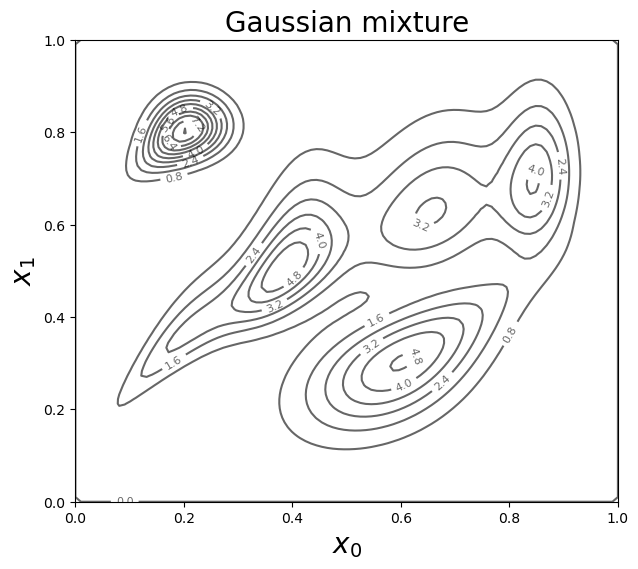

In [5]:
d = ctb.DrawFunctions()
fig = d.draw_2D_controur('Gaussian mixture', None, distribution, nb_isocurves=12, contour_values=True)

In [6]:
dimension = distribution.getDimension()
size = 20
mc_design = distribution.getSample(size)
candidate_set_size = int(1e4)
candidate_set = distribution.getSample(candidate_set_size)

In [7]:
ker_list = [ot.MaternModel([0.1], [1.0], 2.5)] * dimension
kernel = ot.ProductCovarianceModel(ker_list)

In [8]:
kh = otkd.KernelHerding(
    kernel=kernel,
    candidate_set=candidate_set,
    distribution=distribution
)
kh_design, _ = kh.select_design(size)

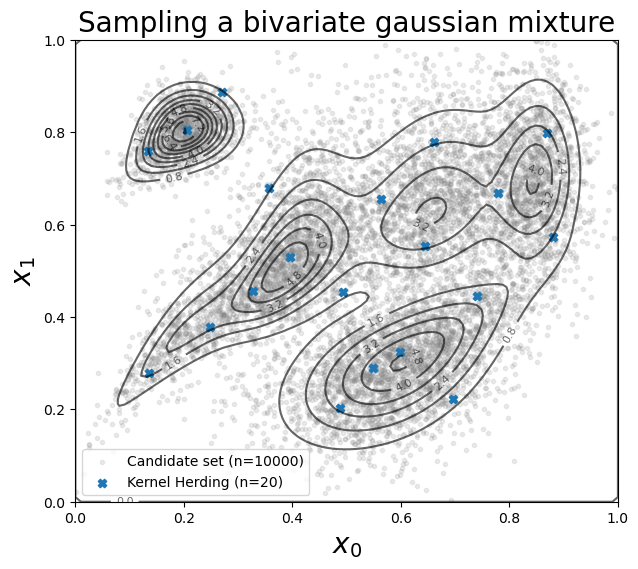

In [9]:
fig = d.draw_2D_controur('Sampling a bivariate gaussian mixture', None, distribution, nb_isocurves=12)
plt.scatter(candidate_set[:, 0], candidate_set[:, 1], label='Candidate set (n={})'.format(candidate_set_size), marker='.', alpha=0.15, color='C7')
plt.scatter(kh_design[:, 0], kh_design[:, 1], label='Kernel Herding (n={})'.format(size), marker='X', color='C0')
plt.legend()
#plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center') # outside bounds
plt.savefig('res/gaussian_mixture_sampling.pdf', bbox_inches='tight');
plt.show()

/home/elias/anaconda3/envs/uqwind/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/elias/anaconda3/envs/uqwind/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


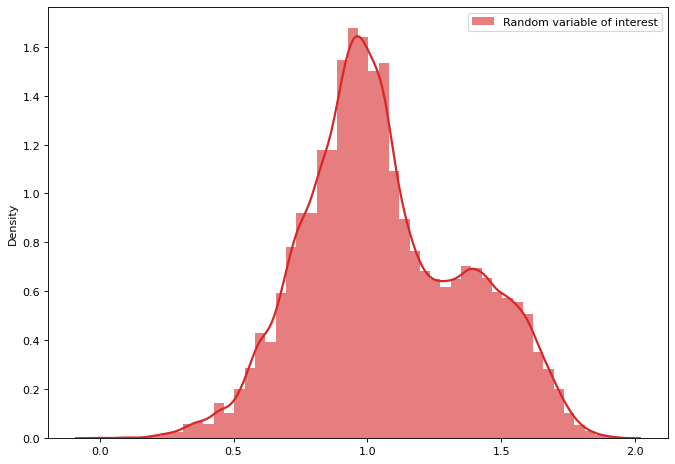

In [10]:
import seaborn as sns
output_rv = problem.getRandomVector()
output_sample = np.array(output_rv.getSample(10000)).flatten()

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'bw':0.1, 'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(output_sample, color="C3", **kwargs, label="Random variable of interest")
#plt.xlim(-0.2, 3.2)
plt.legend();

## Benchmark

In [11]:
#doe_generator = ctb.CentralTendencyBenchmark()
#candidate_points = doe_generator.generate_sample('sobol', 2**12, distribution, None)

In [16]:
x_bench_sizes = list(range(6, 20, 2)) + list(range(20, 50, 5)) + list(range(50, 100, 10)) + list(range(100, 250, 50))
my_methods = ['kernel herding', 'support points', 'monte carlo']
bench = ctb.CentralTendencyBenchmark(my_methods, x_bench_sizes)

In [17]:
bench.scale_coefficient = 0.1
df_benchmark = bench.run_benchmark([problem], candidate_set)
df_benchmark = df_benchmark.reset_index()
#df_benchmark.to_csv('results/ct_benchmark_{}.csv'.format(problem_name), index=False)

START: problem=Gaussian Mixture | method=kernel herding
START: problem=Gaussian Mixture | method=support points
START: problem=Gaussian Mixture | method=monte carlo
DONE: problem=Gaussian Mixture | method=monte carlo
DONE: problem=Gaussian Mixture | method=support points
DONE: problem=Gaussian Mixture | method=kernel herding


In [19]:
df_benchmark

,Problem,Method,Size,mu,m,m*,MMD,weights sum
0,Gaussian Mixture,kernel herding,6,1.063417,1.025099,0.612892,NaN,0.586875
1,Gaussian Mixture,kernel herding,8,1.063417,1.003252,0.711821,NaN,0.693553
2,Gaussian Mixture,kernel herding,10,1.063417,1.063864,0.799221,NaN,0.751562
3,Gaussian Mixture,kernel herding,12,1.063417,1.084181,0.859238,NaN,0.801729
4,Gaussian Mixture,kernel herding,14,1.063417,1.106056,0.914011,NaN,0.844401
...,...,...,...,...,...,...,...,...
58,Gaussian Mixture,support points,80,1.063417,1.065949,1.04211,NaN,0.976227
59,Gaussian Mixture,support points,90,1.063417,1.068116,1.046688,NaN,0.979773
60,Gaussian Mixture,support points,100,1.063417,1.069609,1.04702,NaN,0.980284
61,Gaussian Mixture,support points,150,1.063417,1.064545,1.056782,NaN,0.990255


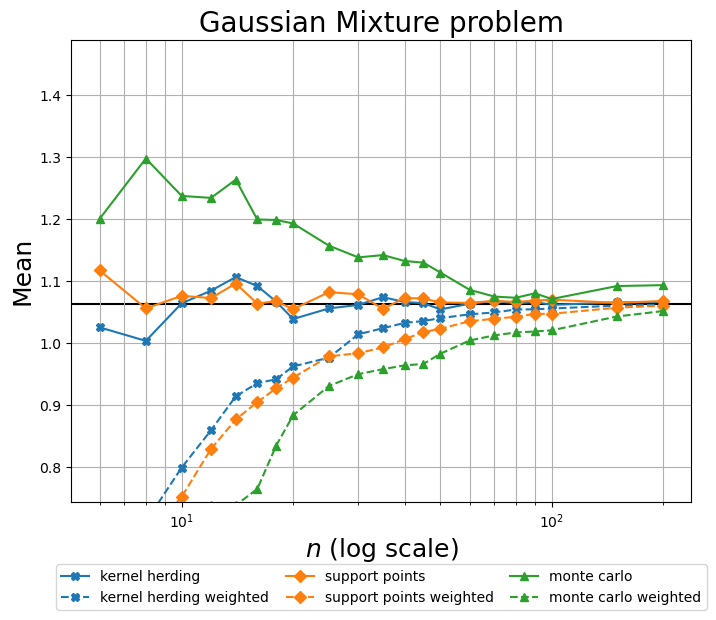

In [18]:
sfile = 'figures/{}_convergence.pdf'.format(problem_name)
#figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=my_methods, save_file=sfile);
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=my_methods);